In [1]:
import mat73
import pandas as pd
import numpy as np
import scipy.io
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

### Data loading and preprocessing

In [2]:
import os

DATA_DIR = ''
if 'google.colab' not in str(get_ipython()):
    if "anuja" in os.environ.get('USER'):
        DATA_DIR = 'data/'
    elif 'ubuntu' in os.environ.get('USER'):
        DATA_DIR = '/home/ubuntu/Martyna/repo/AI4Health/DATAfoof/'
    

In [3]:
# foof = pd.read_csv(DATA_DIR+"sensor_intercept_slope.csv")
# #foof = foof.rename(columns={"C1": "IDs" ,"C2": "Intercept", "C3": "Slope"})
# foof

In [4]:
# data = scipy.io.loadmat(DATA_DIR+'x.mat')  
# df = pd.DataFrame(data['x'].reshape((data['x'].shape[0], -1)))

# # sparsing
# df = np.array(df).reshape(data['x'].shape)
# df_sparsed = np.concatenate([np.expand_dims(df[:,:,i:i+2].mean(axis = 2), axis = 2) for i in range(0, data['x'].shape[2]-2, 2)], axis = 2)
# df = pd.DataFrame(df_sparsed.reshape((df_sparsed.shape[0], -1)))

# #scaling
# norm = MinMaxScaler().fit(df)
# df = norm.transform(df)
# df = pd.DataFrame(df.reshape((df.shape[0], -1)))

# columns = np.asarray([['Electrode %d - %d/2 Hz'%(i+1, j+1)] for i in range(df_sparsed.shape[1]) for j in range(df_sparsed.shape[2])])
# df.columns = columns
# df['IDs'] = foof['IDs']
# df

In [5]:
# beh = pd.read_csv(DATA_DIR+"behaviorals.csv")
# print('Before:'+str(beh.shape))

# most_common_disorders = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
#                          'Autism Spectrum Disorder', 'Disruptive', 'Communication Disorder',
#                          'Depressive Disorders',  'No Diagnosis Given', 'Other Disorders']

# category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)] +\
#                    ['DX_' + str(i).zfill(2) + '_Sub' for i in range(1, 11)]

# # removing patients with incomplete eval
# initial_size = beh.shape[0]
# beh = beh[beh.DX_01 != 'No Diagnosis Given: Incomplete Eval']
# beh = beh.reset_index(drop=True)
# new_size = beh.shape[0]

# print('After:'+str(beh.shape))
# print('Removing', initial_size - new_size,
#       'patients as their evaluations was incomplete.')

In [6]:
# no_diagnosis_given = 'No Diagnosis Given'

# diagnoses_to_ids = {disorder: i for i, disorder in enumerate(most_common_disorders)}
# diagnoses_to_ids

In [7]:
# def get_disorder(data, row, index):
#     disorder = data.iloc[row][category_columns[index]]

#     if disorder == 'Neurodevelopmental Disorders':
#         disorder = data.iloc[row][category_columns[index + 10]]

#     return disorder

# order_of_disorders = []
# for k in range(beh.shape[0]):
#     i = 0
#     disorder = get_disorder(beh, k, i)
#     disorders_patient = []
#     while not pd.isnull(disorder):
#         if disorder in diagnoses_to_ids:
#             if diagnoses_to_ids[disorder] not in disorders_patient:
#                 disorders_patient.append(diagnoses_to_ids[disorder])
#         else:
#             if diagnoses_to_ids['Other Disorders'] not in disorders_patient:
#                 disorders_patient.append(diagnoses_to_ids['Other Disorders'])
#         i += 1
#         if i == len(category_columns):
#             break
#         disorder = get_disorder(beh, k, i)

        
#     order_of_disorders.append(disorders_patient)

In [8]:
# other_disorders = []
# no_diagnosis_given = []
# for i in order_of_disorders:
#     if 7 in i:
#         no_diagnosis_given.append(1)
#         i.remove(7)
#     else:
#         no_diagnosis_given.append(0)
#     if 8 in i:
#         other_disorders.append(1)
#         i.remove(8)
#     else:
#         other_disorders.append(0)

In [9]:
# max_len_order = np.max([len(x) for x in order_of_disorders])

# # pad with a new token denoting the pad token
# pad_token = len(most_common_disorders)
# bod_token = len(most_common_disorders) + 1
# eod_token = len(most_common_disorders) + 2

# order_of_disorders = [[bod_token] + x + [eod_token] + [pad_token] * (max_len_order - len(x)) for x in order_of_disorders]

# order_of_disorders = np.array(order_of_disorders)

# classes = np.zeros((len(most_common_disorders),
#                     beh.shape[0]), dtype=np.int32)

# df_disorders = beh[category_columns]

# for i, disorder in enumerate(most_common_disorders):
#     mask = df_disorders.select_dtypes(include=[object]). \
#         applymap(lambda x: disorder in x if pd.notnull(x) else False)

#     disorder_df = df_disorders[mask.any(axis=1)]

#     np.add.at(classes[i], disorder_df.index.values, 1)

# behaviour_data_columns = beh.columns.values.astype(np.str)

# columns_to_drop = behaviour_data_columns[
#     np.flatnonzero(np.core.defchararray.find(behaviour_data_columns, 'DX') != -1)]

# behaviour_data = beh.drop(columns=columns_to_drop)

# for disorder, classification in zip(most_common_disorders, classes):
#     behaviour_data[disorder] = classification

# behaviour_data['order_diagnoses'] = list(order_of_disorders)

In [10]:
# common_disorders = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
#                          'Autism Spectrum Disorder', 'Disruptive', 'Communication Disorder',
#                          'Depressive Disorders']

# labels=behaviour_data[["IDs"]+list(common_disorders)]
# labels["Other Disorders"] = other_disorders
# labels

In [11]:
# df = pd.merge(df, foof, on='IDs', how='inner')
# df = pd.merge(df, labels, on='IDs', how='inner')
# df

### Data Split

In [12]:
# disorders_list = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
#                          'Autism Spectrum Disorder', 'Disruptive', 'Communication Disorder',
#                          'Depressive Disorders', 'Other Disorders']
# x = df[df.columns.difference(['IDs']+disorders_list)]
# y = df[disorders_list]

# # summarize dataset shape
# print(x.shape, y.shape)

# train_features, test_features, train_labels, test_labels = train_test_split(x, y, test_size=0.25, shuffle=True)

In [13]:
# path = os.path.join(DATA_DIR, 'multilabel_classification_sensor_level')
path = os.path.join(DATA_DIR, 'multilabel_classification_sensor_level_age_gender')

# #saving
# if not(os.path.exists(path)):
#     os.mkdir(path)
# np.save(os.path.join(path, 'train_features.npy'), train_features)
# np.save(os.path.join(path, 'test_features.npy'), test_features)
# np.save(os.path.join(path, 'train_labels.npy'), train_labels)
# np.save(os.path.join(path, 'test_labels.npy'), test_labels)

In [14]:
#loading
train_features = np.load(os.path.join(path, 'train_features.npy'))
test_features = np.load(os.path.join(path, 'test_features.npy'))
train_labels = np.load(os.path.join(path, 'train_labels.npy'))
test_labels = np.load(os.path.join(path, 'test_labels.npy'))

In [15]:
train_labels = np.array(train_labels) 
test_labels = np.array(test_labels) 

## FEATURE EXTRACTION WITH PCA

In [16]:
age_gender = True
if age_gender:
    train_age_gender = train_features[:,-2:]
    test_age_gender = test_features[:,-2:]
    train_features = train_features[:,:-2]
    test_features = test_features[:,:-2]

In [17]:
#scaling features

# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(train_features)

# transform training data
train_features = norm.transform(train_features)
test_features = norm.transform(test_features)

print(train_features.shape, test_features.shape)

(1440, 4305) (481, 4305)


In [18]:
# dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(.95) # 95% variance retained
pca.fit(train_features)

# transform data
train_features = pca.transform(train_features)
test_features = pca.transform(test_features)
print(train_features.shape, test_features.shape)

(1440, 237) (481, 237)


In [19]:
if age_gender:
    train_features = np.concatenate([train_features, train_age_gender], axis = 1)
    test_features = np.concatenate([test_features, test_age_gender], axis = 1)

## FEATURE EXTRACTION WITH AUTOENCODER

In [20]:
# import tensorflow as tf
# from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
# from tensorflow.keras.utils import plot_model, to_categorical

# n_inputs = train_features.shape[1]

# visible = Input(shape=(n_inputs,))
# e = Dense(n_inputs*2)(visible)
# e = BatchNormalization()(e)
# e = LeakyReLU()(e)
# e = Dense(n_inputs)(e)
# e = BatchNormalization()(e)
# e = LeakyReLU()(e)
# n_bottleneck = round(float(n_inputs) / 2.0)
# bottleneck = Dense(n_bottleneck)(e)

# d = Dense(n_inputs)(bottleneck)
# d = BatchNormalization()(d)
# d = LeakyReLU()(d)

# d = Dense(n_inputs*2)(d)
# d = BatchNormalization()(d)
# d = LeakyReLU()(d)

# output = Dense(8, activation='linear')(d)

# model = Model(inputs=visible, outputs=output)
# model.compile(optimizer='adam', loss='mse')
# plot_model(model, 'autoencoder_compress.png', show_shapes=True)

# history = model.fit(train_features, train_labels, epochs=50, batch_size=16, verbose=2)
# encoder = Model(inputs=visible, outputs=bottleneck)

# plot_model(encoder, 'encoder_compress.png', show_shapes=True)
# encoder.save('autoencoder.h5')

In [21]:
# # encode the data
# encoder= load_model('autoencoder.h5', compile=False)

# train_features = encoder.predict(train_features)
# test_features = encoder.predict(test_features)

### Metrics

In [22]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, PrecisionRecallDisplay
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle

n_classes = train_labels.shape[1]

def plot_pr_curve(Y_test, y_score):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict() #actually stores AUC
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
        average_precision[i] = auc(recall[i], precision[i])
#         average_precision[i] = auc(Y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        Y_test.ravel(), y_score.ravel()
    )
#     average_precision["macro"] = auc(recall["micro"], precision["micro"])
    average_precision["macro"] = np.average(list(average_precision.values()))

    _, ax = plt.subplots(figsize=(8, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["macro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i in range(n_classes):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i}")

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title("Precision-Recall curve")
    plt.show()
    
    return average_precision["macro"]
    
def plot_roc_curve(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
   
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["macro"] = np.average(list(roc_auc.values()))
    
    # Plot ROC curve
    plt.rcParams["figure.figsize"] = (8, 8)
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]))
    
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operator characteristics')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc["macro"]

In [23]:
from sklearn.metrics import hamming_loss, accuracy_score
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

def brier_multi(targets, probs):
    return np.mean(np.sum((probs - targets)**2, axis=1))

def evaluate(y_test, y_pred_prob, brier=True):
    y_pred = y_pred_prob.round()
    accuracy = accuracy_score(y_test, y_pred)
    hamming = hamming_loss(y_test, y_pred)
    brier_score = brier_multi(y_test, y_pred_prob)
    report = skm.classification_report(y_test,y_pred, zero_division=1, output_dict=True)
    
    print("Accuracy:", accuracy)
    print("Hamming Loss:", hamming)
    if brier:
        print("Brier Score:", brier_score)
    print("Classification Report:\n", skm.classification_report(y_test,y_pred, zero_division=1))
    print("Confusion matrix:\n", skm.multilabel_confusion_matrix(y_test, y_pred))
    
    return accuracy,  hamming, brier_score, report

## Models

In [24]:
model_names, model_names_all = [], []
accuracy_scores, hamming, brier_score, precision, recall, f1_score, pr_auc, roc_auc = [], [], [], [], [], [], [], []
accuracy_scores_all, hamming_all, brier_score_all, precision_all, recall_all, f1_score_all, pr_auc_all, roc_auc_all = [], [], [], [], [], [], [], []
accuracy_scores_std, hamming_std, brier_score_std, precision_std, recall_std, f1_score_std, pr_auc_std, roc_auc_std = [], [], [], [], [], [], [], []

def record_values(a, h, b, p, r, f, pr, roc,a_std, h_std, b_std, p_std, r_std, f_std, pr_std, roc_std, model_name=''):
    accuracy_scores.append(a)
    hamming.append(h)
    brier_score.append(b)
    precision.append(p)
    recall.append(r)
    f1_score.append(f)
    pr_auc.append(pr)
    roc_auc.append(roc)
    
    accuracy_scores_std.append(a_std)
    hamming_std.append(h_std)
    brier_score_std.append(b_std)
    precision_std.append(p_std)
    recall_std.append(r_std)
    f1_score_std.append(f_std)
    pr_auc_std.append(pr_std)
    roc_auc_std.append(roc_std)
    model_names.append(model_name)

def record_values_all(a, h, b, p, r, f, pr, roc, model_name=''):
    accuracy_scores_all.append(a)
    hamming_all.append(h)
    brier_score_all.append(b)
    precision_all.append(p)
    recall_all.append(r)
    f1_score_all.append(f)
    pr_auc_all.append(pr)
    roc_auc_all.append(roc)
    model_names_all.append(model_name)

In [25]:
def ci(vals):
    return np.percentile(vals, 5), np.percentile(vals, 95)

In [26]:
# specify runs here
n = 10

### Random Baseline

#### mit shuffling

In [27]:
%%capture

import sys, os

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    predicted_labels_shuffled = np.copy(test_labels)
    np.random.shuffle(predicted_labels_shuffled)
    accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_shuffled)
    pr = plot_pr_curve(test_labels, predicted_labels_shuffled)
    roc = plot_roc_curve(test_labels, predicted_labels_shuffled)
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Shuffling Baseline')
    

vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Shuffling Baseline')

#### dummy classifiers

%%capture

from sklearn.dummy import DummyClassifier

n=10
strategies = ['stratified', 'most_frequent', 'uniform']

for strategy_ in strategies:

    a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

    for i in range(n):
        dummy_clf = DummyClassifier(strategy=strategy_)
        dummy_clf.fit(train_features, train_labels)
        predicted_labels = np.asarray(dummy_clf.predict_proba(test_features))[:, :, 1].T
        print('Dummy Classifier-' + strategy_)
        evaluate(test_labels, predicted_labels)
        accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels)
        pr = plot_pr_curve(test_labels, predicted_labels)
        roc = plot_roc_curve(test_labels, predicted_labels)
        
        a_avg.append(accuracy_)
        h_avg.append(hamming_)
        b_avg.append(brier_score_)
        p_avg.append(report_['micro avg']['precision'])
        r_avg.append(report_['micro avg']['recall'])
        f_avg.append(report_['micro avg']['f1-score'])
        pr_avg.append(pr)
        roc_avg.append(roc)

    record_values(np.mean(a_avg),np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg), np.std(a_avg),np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg), 'Dummy Classifier-' + strategy_)


strategies = ['stratified', 'most_frequent', 'uniform']

for strategy_ in strategies:

    a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

    for i in range(n):
        dummy_clf = DummyClassifier(strategy=strategy_)
        dummy_clf.fit(train_features, train_labels)
        predicted_labels = np.asarray(dummy_clf.predict_proba(test_features))[:, :, 1].T
        print('Dummy Classifier-' + strategy_)
        evaluate(test_labels, predicted_labels)
        accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels)
        pr = plot_pr_curve(test_labels, predicted_labels)
        roc = plot_roc_curve(test_labels, predicted_labels)
        
        a_avg.append(accuracy_)
        h_avg.append(hamming_)
        b_avg.append(brier_score_)
        p_avg.append(report_['micro avg']['precision'])
        r_avg.append(report_['micro avg']['recall'])
        f_avg.append(report_['micro avg']['f1-score'])
        pr_avg.append(pr)
        roc_avg.append(roc)

    record_values(np.mean(a_avg),np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg), np.std(a_avg),np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg), 'Dummy Classifier-' + strategy_)



    a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

    for i in range(n):
        dummy_clf = DummyClassifier(strategy=strategy_)
        dummy_clf.fit(train_features, train_labels)
        predicted_labels = np.asarray(dummy_clf.predict_proba(test_features))[:, :, 1].T
        print('Dummy Classifier-' + strategy_)
        evaluate(test_labels, predicted_labels)
        accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels)
        pr = plot_pr_curve(test_labels, predicted_labels)
        roc = plot_roc_curve(test_labels, predicted_labels)
        
        a_avg.append(accuracy_)
        h_avg.append(hamming_)
        b_avg.append(brier_score_)
        p_avg.append(report_['micro avg']['precision'])
        r_avg.append(report_['micro avg']['recall'])
        f_avg.append(report_['micro avg']['f1-score'])
        pr_avg.append(pr)
        roc_avg.append(roc)

    record_values(np.mean(a_avg),np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg), np.std(a_avg),np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg), 'Dummy Classifier-' + strategy_)



    a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

    for i in range(n):
        dummy_clf = DummyClassifier(strategy=strategy_)
        dummy_clf.fit(train_features, train_labels)
        predicted_labels = np.asarray(dummy_clf.predict_proba(test_features))[:, :, 1].T
        print('Dummy Classifier-' + strategy_)
        evaluate(test_labels, predicted_labels)
        accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels)
        pr = plot_pr_curve(test_labels, predicted_labels)
        roc = plot_roc_curve(test_labels, predicted_labels)
        
        a_avg.append(accuracy_)
        h_avg.append(hamming_)
        b_avg.append(brier_score_)
        p_avg.append(report_['micro avg']['precision'])
        r_avg.append(report_['micro avg']['recall'])
        f_avg.append(report_['micro avg']['f1-score'])
        pr_avg.append(pr)
        roc_avg.append(roc)

    record_values(np.mean(a_avg),np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg), np.std(a_avg),np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg), 'Dummy Classifier-' + strategy_)


### Multi Output Classifier

In [28]:
%%capture

from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)

forest = RandomForestClassifier()
lg = LogisticRegression()
models = [lg, forest]

number_of_bootstraps = 10
seed_value = 7

for model in models:
    
    a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []
    for i in range(n):

        multi_output_model = MultiOutputClassifier(model, n_jobs=-1)
        multi_output_model.fit(train_features, train_labels)

        # Boostrap
        resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

        predicted_labels = np.asarray(multi_output_model.predict_proba(resampled_xtest))[:, :, 1].T
        print(str(model)+':')
        accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels)
        pr = plot_pr_curve(resampled_ytest, predicted_labels)
        roc = plot_roc_curve(resampled_ytest, predicted_labels)
        
        a_avg.append(accuracy_)
        h_avg.append(hamming_)
        b_avg.append(brier_score_)
        p_avg.append(report_['micro avg']['precision'])
        r_avg.append(report_['micro avg']['recall'])
        f_avg.append(report_['micro avg']['f1-score'])
        pr_avg.append(pr)
        roc_avg.append(roc)
        record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Multi Output Classifier-'+str(model))
    
    
    vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
    means = [np.mean(v) for v in vals]
    cis = [ci(v) for v in vals]
    record_values(*means, *cis, 'Multi Output Classifier-'+str(model))

In [29]:
print(np.mean(a_avg), np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg), np.std(a_avg), np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg))
accuracy_scores

0.12515592515592516 0.23412162162162162 1.3628251975051975 0.6188755295152393 0.2876862534632495 0.3926807210274784 0.30276551015270214 0.5586795404300338 0.013531093634322646 0.005299735259674843 0.01767995991930327 0.028229915724912232 0.009216680228348323 0.01298017475837436 0.013223989287356937 0.015503064102217403


[0.043451143451143454, 0.09168399168399169, 0.12515592515592516]

## MLP SIMPLE

In [30]:
%%capture

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_mlp(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    n_inputs, n_outputs = train_features.shape[1],train_labels.shape[1]
    mlp = get_mlp(n_inputs, n_outputs)
    mlp.fit(train_features, train_labels, verbose=0, epochs=100)

    # Boostrap
    resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

    predicted_labels_mlp = mlp.predict(resampled_xtest)
    accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels_mlp)

    pr = plot_pr_curve(resampled_ytest, predicted_labels_mlp)
    roc = plot_roc_curve(resampled_ytest, predicted_labels_mlp)
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'MLP-1L')

    
    
vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'MLP-1L')

## MLP complex

In [31]:
%%capture


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_mlp(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(32, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(16, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(16, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(32, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))

    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    n_inputs, n_outputs = train_features.shape[1],train_labels.shape[1]
    mlp = get_mlp(n_inputs, n_outputs)
    mlp.fit(train_features, train_labels, verbose=0, epochs=100)

    # Boostrap
    resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

    predicted_labels_mlp = mlp.predict(resampled_xtest)
    accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels_mlp)

    pr = plot_pr_curve(resampled_ytest, predicted_labels_mlp)
    roc = plot_roc_curve(resampled_ytest, predicted_labels_mlp)
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'MLP-compl')


vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'MLP-compl')

### Binary Relevance
ignores the possible correlations between class labels

In [32]:
%%capture

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB


a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    classifier = BinaryRelevance(GaussianNB())
    classifier.fit(train_features, train_labels)

    # Boostrap
    resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)


    predicted_labels_br = classifier.predict_proba(resampled_xtest)
    accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels_br.toarray())
    
    pr = plot_pr_curve(resampled_ytest, predicted_labels_br.toarray())
    roc = plot_roc_curve(resampled_ytest, predicted_labels_br.toarray())
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Binary relevance')


vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Binary relevance')

### Classfier Chains

In [33]:
%%capture



from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    classifier = ClassifierChain(LogisticRegression())
    classifier.fit(train_features, train_labels)

    # Boostrap
    resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

    predicted_labels_cc = classifier.predict_proba(resampled_xtest)
    accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels_cc.toarray())
    pr = plot_pr_curve(resampled_ytest, predicted_labels_cc.toarray())
    roc = plot_roc_curve(resampled_ytest, predicted_labels_cc.toarray())
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Classifier Chains')


vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Classifier Chains')

### Label Powerset
takes correlations into account!

In [34]:
%%capture

from skmultilearn.problem_transform import LabelPowerset

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    classifier = LabelPowerset(LogisticRegression())
    classifier.fit(train_features, train_labels)

    # Boostrap
    resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

    
    predicted_labels_lp = classifier.predict_proba(resampled_xtest)
    accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels_lp.toarray())
    pr = plot_pr_curve(resampled_ytest, predicted_labels_lp.toarray())
    roc = plot_roc_curve(resampled_ytest, predicted_labels_lp.toarray())
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Label Powerset-LR')

    
vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Label Powerset-LR')

In [35]:
%%capture

from sklearn.ensemble import RandomForestClassifier

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):

    classifier = LabelPowerset(RandomForestClassifier())
    classifier.fit(train_features, train_labels)

    predicted_labels_lp = classifier.predict_proba(test_features)
    accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_lp.toarray())
    pr = plot_pr_curve(test_labels, predicted_labels_lp.toarray())
    roc = plot_roc_curve(test_labels, predicted_labels_lp.toarray())
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Label Powerset-RFC')

    
vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Label Powerset-RFC')

In [36]:
print(np.mean(a_avg), np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg),np.std(a_avg), np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg))

0.12993762993762997 0.23183471933471936 1.3369251767151766 0.6207950161218585 0.2955357142857143 0.400430863720207 0.295036671654586 0.5418105239574462 0.004285972583802142 0.0013068909522536564 0.003353693736345871 0.005991724384995953 0.002102144851231847 0.0026899106858923405 0.0115394809139289 0.012295244979005918


### Visualisation

In [37]:
%matplotlib inline

[0.043451143451143454, 0.09168399168399169, 0.12515592515592516, 0.06548856548856549, 0.053430353430353426, 0.06257796257796258, 0.09792099792099793, 0.08295218295218296, 0.12993762993762997] [(0.035343035343035345, 0.05311850311850312), (0.07214137214137215, 0.10925155925155926), (0.10654885654885655, 0.14667359667359667), (0.04511434511434512, 0.09074844074844075), (0.041372141372141374, 0.06829521829521829), (0.05155925155925156, 0.07525987525987525), (0.07837837837837838, 0.10810810810810811), (0.07027027027027027, 0.09490644490644491), (0.12567567567567567, 0.13742203742203743)]


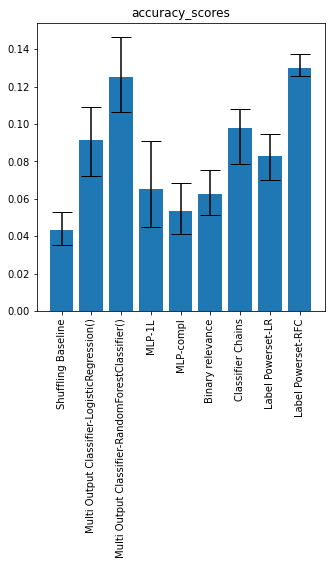

[0.3322765072765073, 0.26465696465696464, 0.23412162162162162, 0.294022869022869, 0.3182692307692308, 0.28791580041580045, 0.2688409563409564, 0.2577962577962578, 0.23183471933471936] [(0.3231288981288981, 0.343477130977131), (0.26005717255717253, 0.27023128898128895), (0.22490904365904366, 0.23990384615384616), (0.2842775467775468, 0.3093035343035343), (0.3057302494802495, 0.33483627858627857), (0.28000259875259875, 0.29604989604989607), (0.2641242203742204, 0.2739345114345114), (0.2518191268191268, 0.26515072765072767), (0.2295608108108108, 0.2335369022869023)]


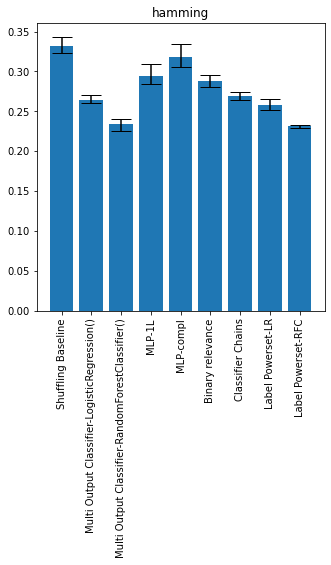

[2.6582120582120585, 1.4881609063148413, 1.3628251975051975, 1.919867465203097, 2.2374338661587063, 1.804934928257564, 1.5448541434891985, 1.4667814275055442, 1.3369251767151766] [(2.585031185031185, 2.747817047817048), (1.4559543376616504, 1.5191384492149578), (1.3316668711018713, 1.3850184095634095), (1.8558961617648513, 2.016408926925322), (2.1306370364522587, 2.385201283078882), (1.7557332399825694, 1.8614528488490838), (1.5049628616347064, 1.5916841223844747), (1.4259801398398575, 1.5055473610722714), (1.3314446673596674, 1.3408287525987526)]


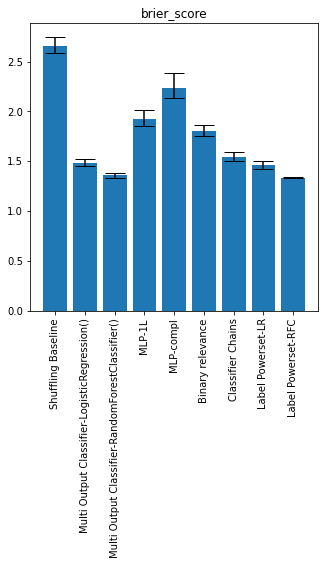

[0.3657738095238095, 0.49540277595109183, 0.6188755295152393, 0.43112104570383086, 0.39033705965301346, 0.4351655447394401, 0.4835976201069297, 0.5177152002574472, 0.6207950161218585] [(0.34439484126984127, 0.38323412698412695), (0.47874503188834455, 0.519757665677547), (0.5814379189275455, 0.6569140757463847), (0.40234824039528083, 0.46204307816766105), (0.3618279626178661, 0.4225417178163132), (0.4132685117585894, 0.4593417553191489), (0.46661985326100336, 0.510697454195513), (0.4816507695420279, 0.5517805919626634), (0.6121440232941731, 0.6306376483591674)]


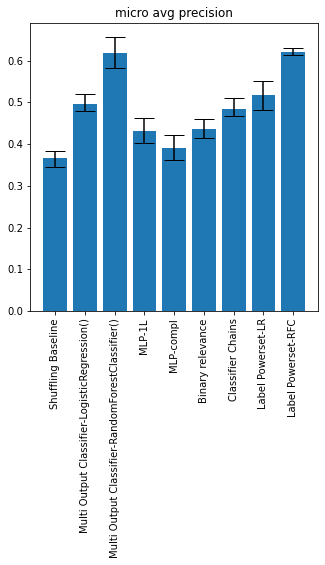

[0.3657738095238095, 0.32969517296120243, 0.2876862534632495, 0.36907734272505544, 0.3719916649867706, 0.3158740449061284, 0.32172210939663176, 0.29933692370434734, 0.2955357142857143] [(0.34439484126984127, 0.38323412698412695), (0.30965491454940086, 0.3471906116642959), (0.2740423387096774, 0.300407747196738), (0.3359658037648221, 0.40384675938074), (0.332550050550174, 0.3960849798966667), (0.304652728788559, 0.33324994090300214), (0.29956920049529534, 0.34133432992776924), (0.2816181539793497, 0.3171833414551861), (0.2925595238095238, 0.29871031746031745)]


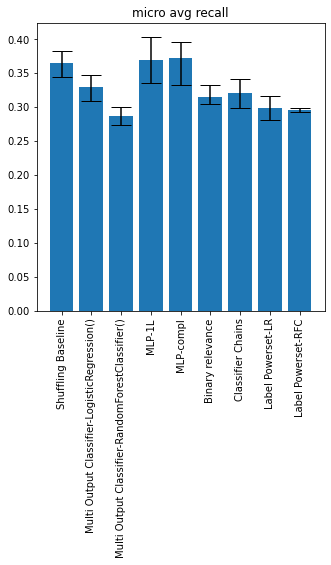

[0.3657738095238095, 0.39585507658400315, 0.3926807210274784, 0.39758774235180594, 0.38062598725716434, 0.36600426004381836, 0.3862559992506386, 0.3792123294459838, 0.400430863720207] [(0.34439484126984127, 0.38323412698412695), (0.377136885600346, 0.4162032762472077), (0.37256425355786876, 0.41), (0.36715952298871507, 0.4300327905384971), (0.34767781482215826, 0.40642789815173525), (0.35074419920393857, 0.3843862349130889), (0.36507712379442464, 0.40476175092543676), (0.3554225435581368, 0.40135617817627506), (0.3973712798368587, 0.40528898834367005)]


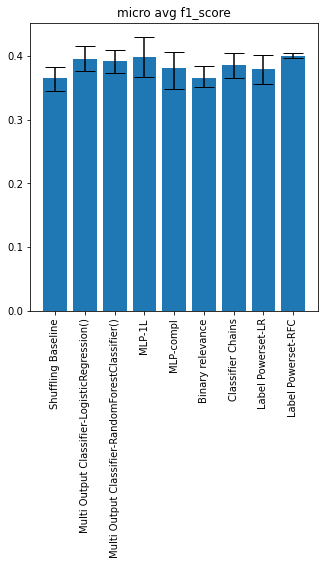

[0.3456224645231705, 0.3135788759089819, 0.30276551015270214, 0.30785299334967037, 0.3024879542513152, 0.3006358671944781, 0.3127235266431748, 0.30141693524078395, 0.295036671654586] [(0.3281570372807857, 0.3625515410417827), (0.2942906649530765, 0.3311771262905813), (0.2795144402826821, 0.31605653633588016), (0.28418259343480157, 0.3268430085411069), (0.28331193141594463, 0.3146380413088764), (0.2834037581424001, 0.31501660142715093), (0.2936000255064387, 0.3289925275768152), (0.28460224643301363, 0.31693313899615383), (0.27970403471449956, 0.3143054483699452)]


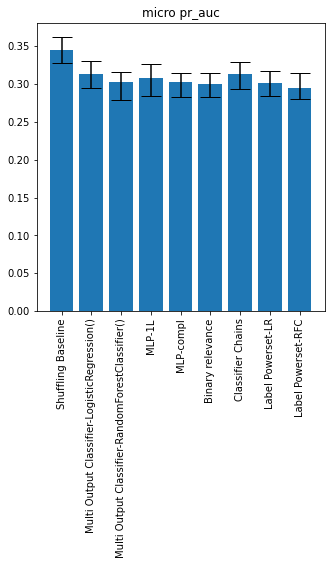

[0.5003959485894953, 0.5774371492761802, 0.5586795404300338, 0.5593787107905747, 0.5427398715596782, 0.5648652126788793, 0.57900907296136, 0.564379407734684, 0.5418105239574462] [(0.4862599547862182, 0.5139927265306339), (0.564833304799712, 0.5844574018365588), (0.5370394162444948, 0.582118040609788), (0.5412909005695085, 0.5717592964874326), (0.5276855923201246, 0.5573393978339984), (0.5455221812159802, 0.575806830828892), (0.5649528283758206, 0.5898881846469853), (0.5492508699036213, 0.5807820677169482), (0.5265541454334594, 0.5615444512523053)]


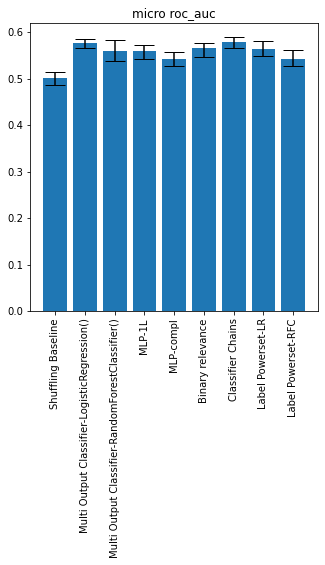

In [39]:
import matplotlib.pyplot as plt

score_names = ['accuracy_scores', 'hamming', 'brier_score', 'micro avg precision', 'micro avg recall', 'micro avg f1_score', 'micro pr_auc', 'micro roc_auc']
for scores, scores_std, score_name in zip([accuracy_scores, hamming, brier_score, precision, recall, f1_score, pr_auc, roc_auc],[accuracy_scores_std, hamming_std, brier_score_std, precision_std, recall_std, f1_score_std, pr_auc_std, roc_auc_std], score_names):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_axes([0,0,1,1])
    print(scores, scores_std)
    scores_std = np.array(list(zip(*scores_std)))
    scores_std[0] = scores - scores_std[0]
    scores_std[1] = scores_std[1] - scores
    ax.bar(model_names, scores, yerr = scores_std, capsize=10)
    plt.xticks(rotation='vertical')
    plt.title(score_name)
    plt.show()

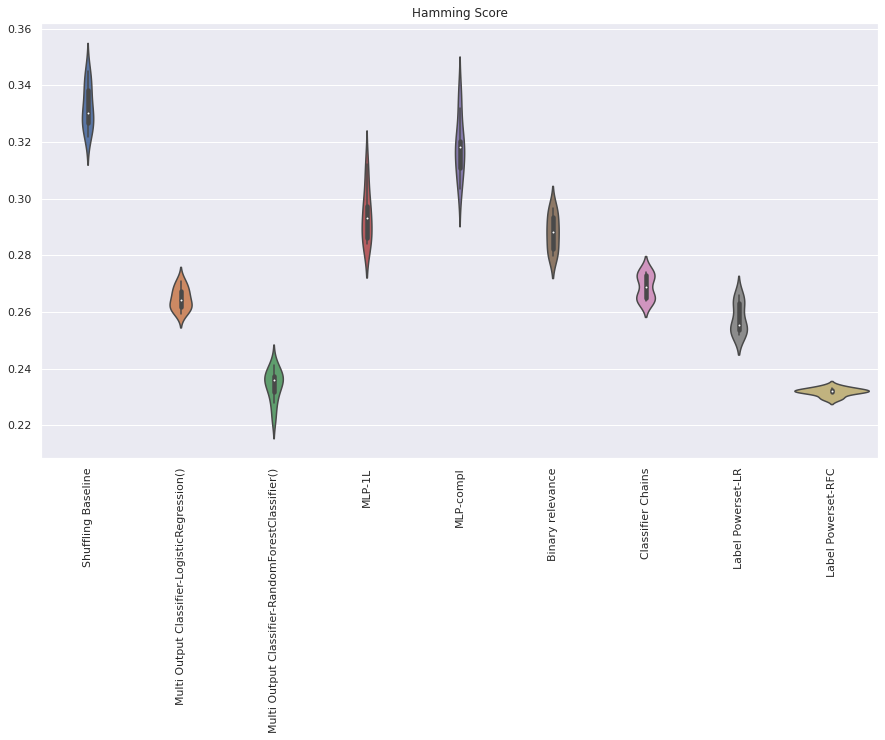

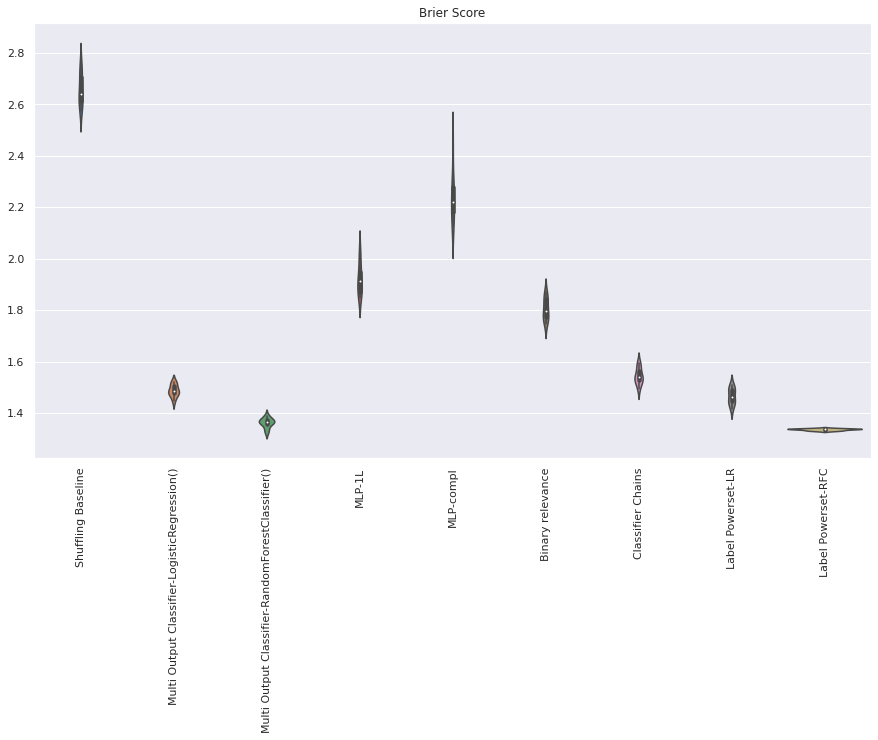

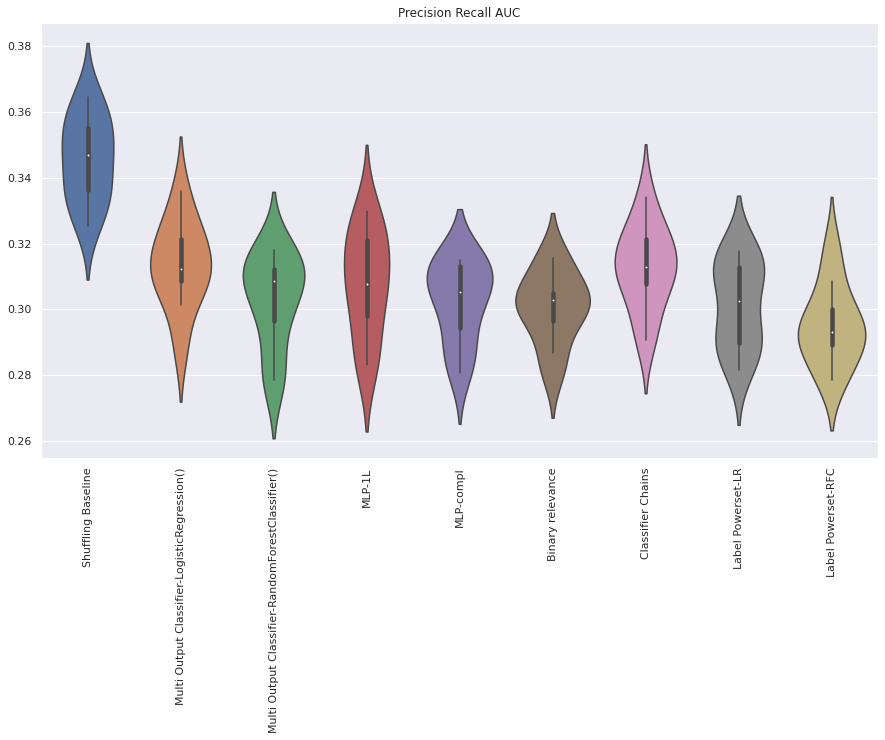

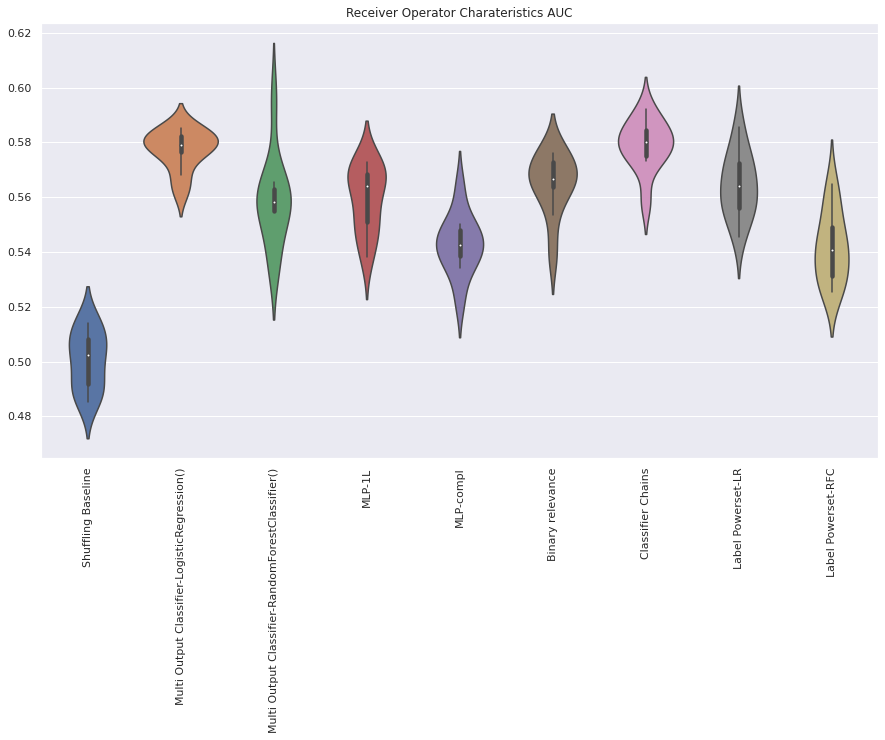

In [72]:
import seaborn as sns
sns.set(style="darkgrid")

# plot
sns.violinplot(y=hamming_all, x=model_names_all)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(15, 8)})
plt.title("Hamming Score")
plt.show()

# plot
sns.violinplot(y=brier_score_all, x=model_names_all)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(15, 8)})
plt.title("Brier Score")
plt.show()

# plot
sns.violinplot(y=pr_auc_all, x=model_names_all)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(15, 8)})
plt.title("Precision Recall AUC")
plt.show()

# plot
sns.violinplot(y=roc_auc_all, x=model_names_all)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(15, 8)})
plt.title("Receiver Operator Charateristics AUC")
plt.show()